<a href="https://colab.research.google.com/github/lav-singh98/cw/blob/master/Neural_style_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neural Style Transfer

## Introduction

This tutorial demonstrates how to use the Neural-Style algorithm created by Matthias Bethge, Alexander S. Ecker, and Leon A. Gatys. Neural transfer is used to take a picture and recreate it in a different aesthetic manner. The algorithm alters the input to match the content of the content-image and the artistic style of the style-image by using three images—an input picture, a content-image, and a style-image.

## The core concept

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content
is between two images while $D_S$ measures how different the style is
between two images. Then, we take a third image, the input, and
transform it to minimize both its content-distance with the
content-image and its style-distance with the style-image. Now we can
import the necessary packages and begin the neural transfer.

## Importing Packages and Selecting a Device
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pretrained models)
-  ``copy`` (to deep copy the models; system package)



# Implementation

 Following code renders the figure in a notebook (instead of displaying on window).

In [1]:
%matplotlib inline

## Importing Packages and Selecting a Device
Below is a list of the packages needed to implement the neural transfer.

torch, torch.nn, numpy (indispensables packages for neural networks with PyTorch)
torch.optim (efficient gradient descents)
PIL, PIL.Image, matplotlib.pyplot (load and display images)
torchvision.transforms (transform PIL images into tensors)
torchvision.models (train or load pretrained models)
copy (to deep copy the models; system package)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device.



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # choose GPU device if available, else choose CPU for underlying execution.
torch.set_default_device(device)  # Set the device chosen on previous statement

## Loading the Images

The style and content images are loaded. As the image is 8-bit, the original PIL images values range between 0 and 255. These images are then transformed into torch tensors. After transformation into torch tensors, their values are converted to be between 0 and 1. Both images are resized to have the same dimensions.

In [4]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)  # open the image and load
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)  # Porting the image to GPU if chosen

style_img_list = ["Style3_1.jpg", "Style2_1.jpg"]  # Append this list to test more images. Provide full path of the images

style_img = image_loader("Style3_1.jpg")
content_img = image_loader("Fam_1.jpg")  # Loading content image.

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

Function that displays an image by reconverting a copy of it to PIL format and displaying the copy. The content and style images are displayed to ensure they were imported correctly.



## Visualization of style and content image

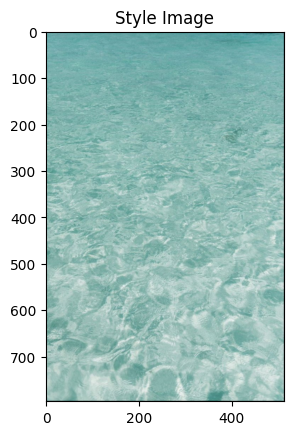

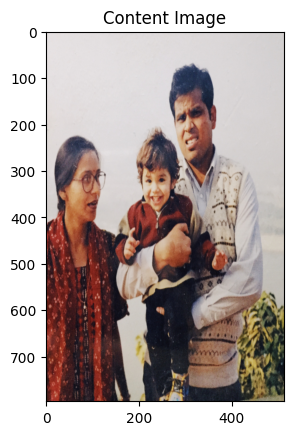

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Functions
Content Loss
~~~~~~~~~~~~

The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer’s input. The computed loss is saved as a
parameter of the module.




In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

The style loss module is implemented similarly to the content loss
module. It will act as a transparent layer in a
network that computes the style loss of that layer. In order to
calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram
matrix is the result of multiplying a given matrix by its transposed
matrix. In this application the given matrix is a reshaped version of
the feature maps $F_{XL}$ of a layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$\ x\ $N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the
length of any vectorized feature map $F_{XL}^k$. For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.

Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield
larger values in the Gram matrix. These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. Style features tend to be in the deeper layers of the
network so this normalization step is crucial.




In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.




In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing the Model

Now we need to import a pretrained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.




In [9]:
cnn = models.vgg19(pretrained=True).features.eval()  # Change vgg16 to vgg19 to load vgg19 model.

# For more information on VGG use following link: https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 73.3MB/s]


Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (``Conv2d``, ``ReLU``, ``MaxPool2d``,
``Conv2d``, ``ReLU``…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




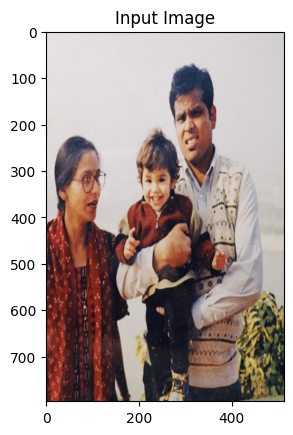

In [12]:
input_img = content_img.clone() # Cloning original image

plt.figure()
imshow(input_img, title='Input Image') # Displaying input image

## Gradient Descent

As Leon Gatys, the author of the algorithm, suggested [here](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq)_, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimize the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Function is defined that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamically compute their gradients. The optimizer requires a “closure”
function, which reevaluates the module and returns the loss.

The values of tensors are ranged between 0 and 1.




In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

The new directory is created!
Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 61.385406 Content Loss: 10.937353

run [100]:
Style Loss : 17.143480 Content Loss: 9.754438

run [150]:
Style Loss : 8.705464 Content Loss: 8.336743

run [200]:
Style Loss : 5.531909 Content Loss: 7.328789

run [250]:
Style Loss : 3.012104 Content Loss: 6.712589

run [300]:
Style Loss : 1.761832 Content Loss: 6.136991



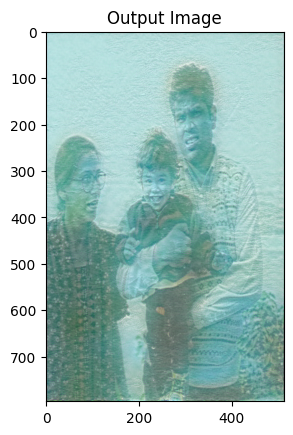

The new directory is created!
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 67.313744 Content Loss: 10.309176

run [100]:
Style Loss : 36.903965 Content Loss: 9.680534

run [150]:
Style Loss : 28.009262 Content Loss: 8.665177

run [200]:
Style Loss : 18.215258 Content Loss: 8.072704

run [250]:
Style Loss : 12.508297 Content Loss: 7.008291

run [300]:
Style Loss : 9.246287 Content Loss: 6.144999



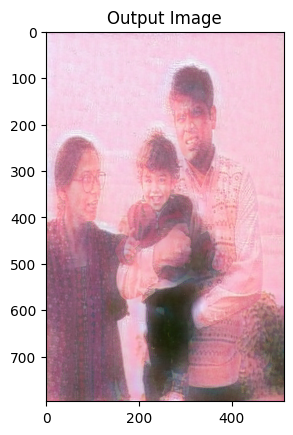

In [15]:
style_img_list = ["Style3_1.jpg", "Style2_1.jpg"]  # List which stores style images. Append this list for testing more images.
from torchvision.utils import save_image
import os

content_img = image_loader("Fam_1.jpg")  # Loading content image

base_folder_name = "/content"  # Base folder to save the output files.

for each in style_img_list:
  style_img = image_loader(each) # loading each style image

  file_path = os.path.basename(os.path.normpath(each)) # Extract the final parts of the filename eg. Style2_1.jpg
  folder_name = file_path[:-4]  # Extract Style2_1 from Style2_1.jpg

  full_folder_path = os.path.join(base_folder_name, folder_name) # Join the base folder name and current folder name

  isExist = os.path.exists(full_folder_path)
  if not isExist:

    # Create a new directory because it does not exist
    os.makedirs(full_folder_path)
    print("The new directory is created!")

  input_img = content_img.clone()
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)   # Execute the Style transfer algorithm

  save_path = os.path.join(full_folder_path, folder_name+ '_result.png') # Save the output style transfered image after appending result.png to its name
  save_image(output, save_path)  # save the output file

  plt.figure()
  imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
  plt.ioff()
  plt.show()

Loss Graph over Optimization steps

run [50]:
Style Loss : 70.939186 Content Loss: 11.024014

run [100]:
Style Loss : 18.381741 Content Loss: 9.847096

run [150]:
Style Loss : 9.032231 Content Loss: 8.382990

run [200]:
Style Loss : 5.754631 Content Loss: 7.337019

run [250]:
Style Loss : 3.087264 Content Loss: 6.748775

run [300]:
Style Loss : 1.753994 Content Loss: 6.151177



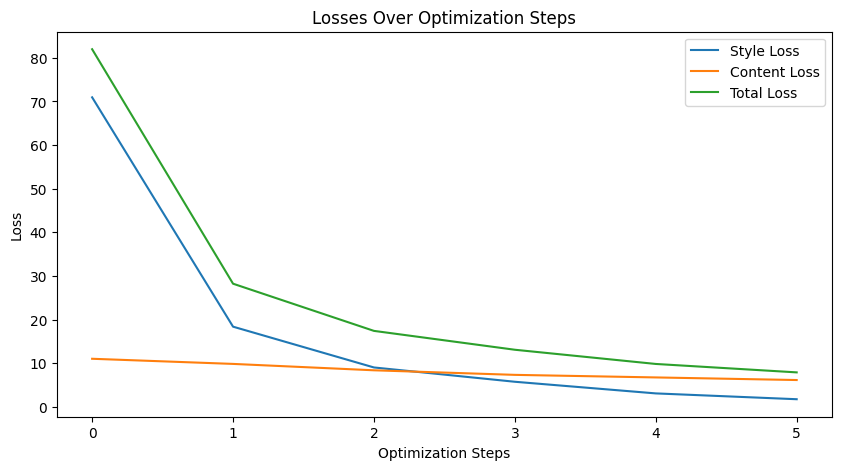

In [16]:
import matplotlib.pyplot as plt

def plot_losses(style_losses, content_losses, total_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(style_losses, label='Style Loss')
    plt.plot(content_losses, label='Content Loss')
    plt.plot(total_losses, label='Total Loss')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    plt.title('Losses Over Optimization Steps')
    plt.legend()
    plt.show()

def run_style_transfer_with_logging(cnn, normalization_mean, normalization_std,
                                    content_img, style_img, input_img, num_steps=300,
                                    style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    style_losses_log = []
    content_losses_log = []
    total_losses_log = []

    run = [0]
    while run[0] <= num_steps:

        def closure():
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1

            if run[0] % 50 == 0:
                style_losses_log.append(style_score.item())
                content_losses_log.append(content_score.item())
                total_losses_log.append(loss.item())
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    plot_losses(style_losses_log, content_losses_log, total_losses_log)
    return input_img

# Choose your style image and content image
style_img = image_loader("Style3_1.jpg")
content_img = image_loader("Fam_1.jpg")

# Choose other hyperparameters
num_steps = 300
style_weight = 1000000
content_weight = 1

# Create a new input image for logging
input_img_logging = content_img.clone()

# Run style transfer with logging
output_logging = run_style_transfer_with_logging(cnn, cnn_normalization_mean, cnn_normalization_std,
                                                 content_img, style_img, input_img_logging,
                                                 num_steps=num_steps,
                                                 style_weight=style_weight,
                                                 content_weight=content_weight)
